## DCGAN using MNIST

In [1]:
# Import Dependencies
import numpy as np

from tqdm import tqdm

# Dataset
from keras.datasets.mnist import load_data

from keras.models import Sequential

# Common Layers
from keras.layers import Dense, Activation, BatchNormalization, Reshape, Flatten 
from keras.optimizers import Adam

# Layers specific to Generator
from keras.layers import Conv2DTranspose

# Layers specific to Discriminator
from keras.layers import Conv2D, LeakyReLU 

# Use this to pass an element-wise TensorFlow/Theano/CNTK function as an activation
import keras.backend as k

# Train Test Split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


For this code, I'll be starting with the MNIST Dataset and then using the same architecture on other datasets like CIFAR, Faces Dataset etc.

The MNIST dataset will be laoded using the Keras "load_data" functionality. When we load the data using this, it is loaded into training and test set as a tuple of each. i.e. a tuple of training features and labels and a tuple of test features and labels.

### Load Dataset and Visualize Data

In [2]:
# Load Dataset
(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
# Get Data Analysis
print('Training Data: \n')
print('Num. Features: ',len(X_train)), print('Num. Labels: ',len(y_train))
print('Shape of Features: ',X_train.shape), print('Shape of Labels: ',y_train.shape)
print('\n\n')

print('Test Data: \n')
print('Num. Features: ',len(X_test)), print('Num. Labels: ',len(y_test))
print('Shape of Features: ',X_test.shape), print('Shape of Labels: ', y_test.shape)

Training Data: 

Num. Features:  60000
Num. Labels:  60000
Shape of Features:  (60000, 28, 28)
Shape of Labels:  (60000,)



Test Data: 

Num. Features:  10000
Num. Labels:  10000
Shape of Features:  (10000, 28, 28)
Shape of Labels:  (10000,)


(None, None)

In [4]:
# Shape of One Image
rand_idx = np.random.randint(0, len(X_train), 1)
print('Shape of one Image: ', X_train[rand_idx].shape)

Shape of one Image:  (1, 28, 28)


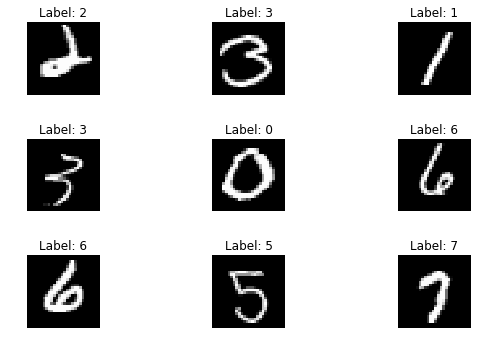

In [5]:
# Visualize Images
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,5))
for i in range(0,3):
    for j in range(0,3):
        idx = np.random.randint(0, len(X_train), 1)
        idx = idx[0]
        ax[i,j].imshow(X_train[idx], cmap='gray')
        ax[i,j].set_axis_off()
        ax[i,j].title.set_text('Label: {}'.format(y_train[idx]))
        plt.tight_layout()

## Data Preprocessing

According to the paper, the input images were scaled to the range of the tanh activation function i.e. [-1,1]. Using this ensures that each input parameter i.e. the pixels in the case of images have a similar data distribution. This helps as it speeds up the convergence while training the model. So, next, we'll write a function that does just that.

In [6]:
# Taking a random image and looking at its pixel values
idx = np.random.randint(0, len(X_train), 1)
print('Image Index No.: ', idx)
print('\nImage Pixel Values [Before Normalization]: \n\n',X_train[idx])
print('\n\n Shape of Image: ',X_train[idx].shape)

Image Index No.:  [30841]

Image Pixel Values [Before Normalization]: 

 [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0  72 255 178  12   0
     0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0  86 232 253 253 211 142
    27   0   0   0 

In [7]:
# Function to apply Normalization similar to tanh activation function range i.e. [-1,1]
def normalize_images(img):
    img = img.reshape(-1,28,28,1)
    img = np.float32(img)
    img = (img / 255 - 0.5) * 2
    img = np.clip(img, -1, 1)
    return img

In [8]:
# Function to DeNormalize the Images once we are done Training the DCGAN Model
def denormalize_images(img):
    img = (img / 2 + 1) * 255
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = img.reshape(28, 28)
    return img

In [9]:
# Reshape Training and Testing Data to add 4 Dimension for Dense Layer [as per paper]
#X_train = X_train.reshape(-1, 28,28,1)
#X_test = X_test.reshape(-1,28,28,1)

In [10]:
# Normalize the Training and Test Features
X_train = normalize_images(X_train)
X_test = normalize_images(X_test)

In [11]:
# Test the Function
#img = normalize_images(X_train[3337])
#print('Normalized Pixel Values: \n\n', img)
#print('\n\n Shape of Normalized Image: ', img.shape)

In [12]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## DCGAN Generator Architecture

The paper describes the DCGAN Architecture as shown in the following image:

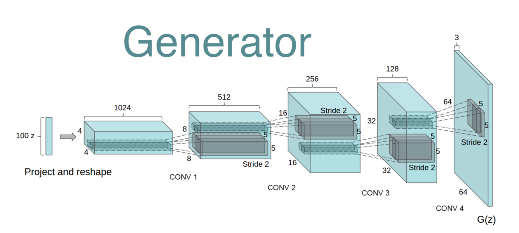

In [13]:
# Display Generator Architecture
from IPython.display import Image
Image(filename='./Images/generator.png', width=900) 

The Generator for DCGAN has the following components:

**1. Input Layer [Dense]:**

This layer is where we provide the noise Input using which, over time and training the Generator is able to convert into an image at the output.

This layer is a Fully Connected or Dense layer that takes the pixels of the image in the current case. Since, we know that the MNIST Image has a shape of [28,28,1], so the total number of Input values is 28*28 = 784.

**2. Reshape:**

Before giving the data into the Transposed Convolution function, we need to resize the input data so that we can apply convolution operation on it.

Input Shape: **[1,784]**

After Reshaping, Input to Transpose Convolution Function: **[4,4,1024]**

**3. 2-D Transposed Convolution [Conv2DTranspose]:**

As per the architecture of DCGAN mentioned in the paper, the Generator performs a series of Transposed Convolutions after getting the data from the dense layer and at the final layer we get a 64x64 image from these high level representations.

**4. Activation Functions [ReLU, Tanh]:**

As per the paper, the Transposed Convolution layers use the ReLU activation function whereas we use a tanh activation function for the final layer. Using the bounded activation function allows the model to learn more quickly to saturate and cover the color space of the training distribution.

So, let's define the Generator Function.

In [14]:
# Generator
def generator(inputSize):
    generator_model = Sequential()
    # Input Dense Layer
    generator_model.add(Dense(7*7*128, input_shape=(inputSize,)))
    # Reshape the Input, apply Batch Normalization and Leaky ReLU Activation.
    generator_model.add(Reshape(target_shape=(7,7,128)))
    generator_model.add(BatchNormalization())
    generator_model.add(Activation('relu'))
    
    # First Transpose Convolution Layer
    generator_model.add(Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'))
    generator_model.add(BatchNormalization())
    generator_model.add(Activation('relu'))
        
    # Since, we are using MNIST Data which has only 1 channel, so filter for Generated Image = 1
    generator_model.add(Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same'))
    generator_model.add(Activation('tanh'))
    
    generator_model.summary()
    
    return generator_model

## DCGAN Discriminator Architecture

The paper describes the DCGAN Architecture as shown in the following image:

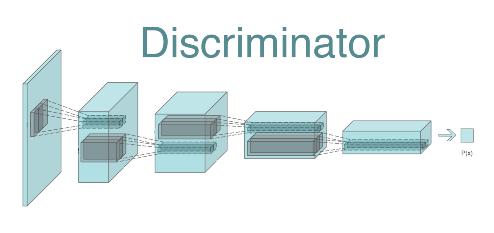

In [15]:
# Display Discriminator Architecture
from IPython.display import Image
Image(filename='./Images/discriminator.png', width=900) 

The discriminator for DCGAN has the following components:

**1. 2-D Convolution [Conv2D]:**

Since, the aim of the discriminator is to classify images between real and fake, it takes in the complete image generated by the generator and try to tell that whether it is a true or a fake image. Hence, CNN comes into play as they are the state of the art networks for image classification. So, we use Convolution filters for the first 3 layers as opposed to Transpose Convolution in the Generator.


**2. Activation Functions [LeakyReLU]:**

As per the paper, the Convolution layers use the LeakyReLU activation function throughout the discriminator layers. Using the bounded activation function allows the model to learn more quickly to saturate and cover the color space of the training distribution.

In [16]:
# Discriminator
def discriminator(leakSlope):
    discriminator_model = Sequential()
    
    # Input and First Conv2D Layer
    discriminator_model.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)))
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Second Conv2D Layer
    discriminator_model.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Third Layer
    discriminator_model.add(Flatten())
    discriminator_model.add(Dense(784))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=leakSlope))
    
    # Output Layer
    discriminator_model.add(Dense(1))
    discriminator_model.add(Activation('sigmoid'))
    
    discriminator_model.summary()
    
    return discriminator_model

In [17]:
# Define DCGAN Architecture
def DCGAN(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, show_summary=False):
    
    # Clear Session
    k.clear_session()
    
    # Generator
    gen = generator(inputSize=100)
    
    # Discrimintor
    dis = discriminator(leakSlope=0.2)
    dis.compile(loss='binary_crossentropy', optimizer=Adam(lr=discriminator_lr, beta_1=discriminator_momentum))
    
    dis.trainable = False
    
    dcgan = Sequential([gen, dis])
    dcgan.compile(loss='binary_crossentropy', optimizer=Adam(lr=generator_lr, beta_1=generator_momentum))
    
    if show_summary == True:
        print("\n Generator Model Summary: \n")
        gen.summary()
        
        print("\n\n Discriminator Model Summary: \n")
        dis.summary()
        
        print("\n\nDCGAN Model Summary\n")
        dcgan.summary()
    
    return dcgan, gen, dis

In [18]:
# Function to Plot Images
def plot_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = denormalize_images(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

In [19]:
# Function to Train the Model
def train_model(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, epochs, batch_size, eval_size, smooth):
    
    # To Do: Add Label Noise Data
    # Training Labels [Real, Fake]
    training_labels = [np.ones([batch_size, 1]), np.zeros([batch_size, 1])]
    
    # Test Labels [Real, Fake]
    test_labels = [np.ones([eval_size, 1]), np.zeros([eval_size, 1])]
    
    # Total Number of Batches = (Total Training Images / Images per Batch)
    num_batches = (len(X_train) // batch_size)
    
    # Call the DCGAN Architecture
    dcgan, generator, discriminator = DCGAN(sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, show_summary=False)
    
    # Array to Store Cost/Loss Values
    cost = []
    
    # Train the Generator and Discriminator
    for i in range(epochs):
        for j in range(num_batches):
            
            # Noise Input for Generator
            # Mean = 0, Stddev = 1
            noise_data = np.random.normal(loc=0, scale=1, size=(batch_size, sample_size))
            
            # Make Predictions using Generator and Generate Fake Images
            fake_images = generator.predict_on_batch(noise_data)
            
            # Load MNIST Data in Batches
            # [0:128], [128:256], ...
            train_image_batch = X_train[j*batch_size:(j+1)*batch_size]
            
            # Train the Discriminator
            discriminator.trainable = True
            
            # Train the Discriminator on Training Data and Labels
            discriminator.train_on_batch(train_image_batch, training_labels[0] * (1 - smooth))
            
            # Train Discriminator on Fake Generated Images and Labels
            discriminator.train_on_batch(fake_images, training_labels[1])
            
            # Set Discriminator training to False when Generator is Training
            discriminator.trainable = False
            
            # Train the Generator on Noise Data Input with Training Labels to reduce Cost/Loss
            # This way, the Discriminator gets trained twice for each one training step of Generator
            dcgan.train_on_batch(noise_data, training_labels[0])
        
            
        # To Do: Add Eval Code
        # Eval/Test Features [Real,Fake]
        real_eval_features = X_test[np.random.choice(len(X_test), size= eval_size, replace=False)]
        
        # Eval Noise Data
        noise_data = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size)) 
        
        # Fake Eval Features: Creates the Images to Fool the Discriminator
        fake_eval_features = generator.predict_on_batch(noise_data)
        
        # Calculate Loss
        # Discriminator Loss: Actual Training Loss for Classification + Loss on Fake Data
        discriminator_loss  = discriminator.test_on_batch(real_eval_features, test_labels[0])
        discriminator_loss += discriminator.test_on_batch(fake_eval_features, test_labels[1])
        
        # Generator Loss: DCGAN Loss
        generator_loss  = dcgan.test_on_batch(noise_data, test_labels[0])
        
        # Add calculated cost/loss to array for plotting
        cost.append((discriminator_loss, generator_loss))
        
        print("Epochs: {0}, Generator Loss: {1}, Discriminator Loss: {2}".format(i+1, generator_loss, discriminator_loss))
        #print("Generated Image: \n", fake_eval_features)
        #print("Gen. Image Shape: \n", fake_eval_features.shape)
        #print("Reshaped Image: \n", fake_eval_features.reshape(28,28))
        # Plot the Images and Save them after every 20 epochs
        if ((i+1)%3 == 0):
            plot_images(fake_eval_features)
        
    # Save Trained Models
    generator.save('./mnist_generator.h5')
    discriminator.save('./mnist_discriminator.h5')
    dcgan.save('./mnist_dcgan.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
__________

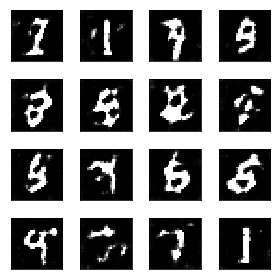

Epochs: 4, Generator Loss: 13.873744010925293, Discriminator Loss: 13.826478958129883


KeyboardInterrupt: 

In [20]:
# sample_size, generator_lr, generator_momentum, discriminator_lr, discriminator_momentum, leakyAlpha, epochs, batch_size, eval_size, smooth
train_model(sample_size=100,generator_lr=0.0001, generator_momentum=0.9, discriminator_lr=0.001, discriminator_momentum=0.9, leakyAlpha=0.01, epochs=100, batch_size=128, eval_size=16, smooth=0.1);